In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN_DIR = '../input/siim-isic-melanoma-classification/jpeg/train'

In [4]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
df_train, df_test = train_test_split(train[:3000], test_size=0.2)

<AxesSubplot:title={'center':'Melanoma distribution'}>

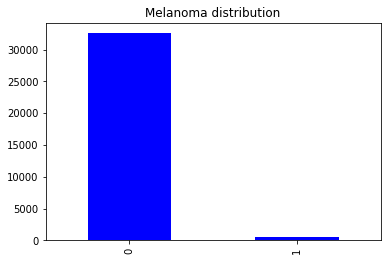

In [6]:
train['target'].value_counts().plot(kind = 'bar', color='blue', title = 'Melanoma distribution' )

In [7]:
ds_train_mal=df_train.loc[df_train['target']==1]
ds_train_ben=df_train.loc[df_train['target']==0]

ds_train=ds_train_mal.append(ds_train_ben, ignore_index=True)

ds_test_mal=df_test.loc[df_test['target']==1]
ds_test_ben=df_test.loc[df_test['target']==0]

ds_test=ds_test_mal.append(ds_test_ben, ignore_index=True)

weight_for_benign = (1 / len(ds_test_ben)) * (len(ds_train) / 2.0)
weight_for_malignant = (1 / len(ds_test_mal)) * (len(ds_test) / 2.0)

class_weight = {0: weight_for_benign, 1: weight_for_malignant}

print('Weight for class benign: {:.2f}'.format(weight_for_benign))
print('Weight for class malignant: {:.2f}'.format(weight_for_malignant))


Weight for class benign: 2.03
Weight for class malignant: 37.50


In [8]:
ds_train['path'] = TRAIN_DIR + "/"+ ds_train.image_name + ".jpg"
ds_test['path'] = TRAIN_DIR + "/"+ ds_test.image_name + ".jpg"
ds_train_images= ds_train[['path', 'target']]
ds_test_images= ds_test[['path', 'target']]

In [9]:
images = []
labels=[]
# loop over the indexes of the melonoma
for i in range(len(ds_train_images[:1000])):
    image = cv2.imread(ds_train_images.iloc[i,0])
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(ds_train_images.iloc[i,1])
images = np.array(images) / 255.0

In [16]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224,3), include_top=False, weights='imagenet')
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(x=np.array(images), y=np.array(labels),
                    steps_per_epoch=100, 
                    epochs=50,
                    class_weight=class_weight,
)

Epoch 1/50
100/100 [==============================] - 234s 2s/step - loss: 5.9241 - accuracy: 0.9030
Epoch 2/50
100/100 [==============================] - 233s 2s/step - loss: 4.0095 - accuracy: 0.5800
Epoch 3/50
100/100 [==============================] - 225s 2s/step - loss: 2.2242 - accuracy: 0.5570
Epoch 4/50
100/100 [==============================] - 228s 2s/step - loss: 3.2338 - accuracy: 0.5430
Epoch 5/50
100/100 [==============================] - 227s 2s/step - loss: 2.3642 - accuracy: 0.6210
Epoch 6/50
100/100 [==============================] - 225s 2s/step - loss: 2.5555 - accuracy: 0.8630
Epoch 7/50
100/100 [==============================] - 231s 2s/step - loss: 1.9527 - accuracy: 0.7580
Epoch 8/50
100/100 [==============================] - 227s 2s/step - loss: 1.7622 - accuracy: 0.7190
Epoch 9/50
100/100 [==============================] - 228s 2s/step - loss: 1.7858 - accuracy: 0.6810
Epoch 10/50
100/100 [==============================] - 234s 2s/step - loss: 1.8622 - accura

In [19]:
model.save('./imageModel.h5')

In [20]:
train_dataset=ds_train[['age_approx',  'sex', 'anatom_site_general_challenge','diagnosis', 'target']]
#Converting to onehot vector
sex_dummies = pd.get_dummies(train_dataset['sex'], prefix='sex')
train_dataset = pd.concat([train_dataset, sex_dummies], axis=1)
anatom_dummies = pd.get_dummies(train_dataset['anatom_site_general_challenge'], prefix='anatom')
train_dataset = pd.concat([train_dataset, anatom_dummies], axis=1)
diag_dummies = pd.get_dummies(train_dataset['diagnosis'], prefix='diagnosis')
train_dataset = pd.concat([train_dataset, diag_dummies], axis=1)
train_dataset_y= train_dataset['target']
train_dataset.drop(['target'], axis=1, inplace=True)
train_dataset.head(2)

,age_approx,sex,anatom_site_general_challenge,diagnosis,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity,diagnosis_lentigo NOS,diagnosis_lichenoid keratosis,diagnosis_melanoma,diagnosis_nevus,diagnosis_seborrheic keratosis,diagnosis_unknown
0,45.0,male,torso,melanoma,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,75.0,female,head/neck,melanoma,1,0,1,0,0,0,0,0,0,0,1,0,0,0


In [21]:
model_ann = tf.keras.Sequential()
model_ann.add(tf.keras.layers.Dense(32, input_dim=15, activation='relu'))
model_ann.add(tf.keras.layers.Dense(12, activation='relu'))
model_ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [27]:
train_dataset.drop(columns = ['sex', 'anatom_site_general_challenge', 'diagnosis'], inplace =True)

In [29]:
model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_tab = model_ann.fit(train_dataset, train_dataset_y, epochs=10, batch_size=64, class_weight=class_weight)

Epoch 1/10
38/38 [==============================] - 1s 4ms/step - loss: 3.4659 - accuracy: 0.7208
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 1.7085 - accuracy: 0.9850
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 1.6675 - accuracy: 0.9850
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 1.6280 - accuracy: 0.9850
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 1.5916 - accuracy: 0.9850
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 1.5592 - accuracy: 0.9850
Epoch 7/10
38/38 [==============================] - 0s 2ms/step - loss: 1.5296 - accuracy: 0.9850
Epoch 8/10
38/38 [==============================] - 0s 2ms/step - loss: 1.5039 - accuracy: 0.9850
Epoch 9/10
38/38 [==============================] - 0s 2ms/step - loss: 1.4806 - accuracy: 0.9850
Epoch 10/10
38/38 [==============================] - 0s 2ms/step - loss: 1.4610 - accuracy: 0.9850


In [30]:
model_ann.save('./modelText.h5')

In [31]:
num_output_layers=1
concate = tf.keras.layers.concatenate([model.layers[-1].output, model_ann.layers[-1].output])
output_1=tf.keras.layers.Dense(units=num_output_layers, activation="sigmoid", name="num_01_output")(concate)
concate_model= tf.keras.Model(inputs=[model.input, model_ann.input], outputs=output_1)

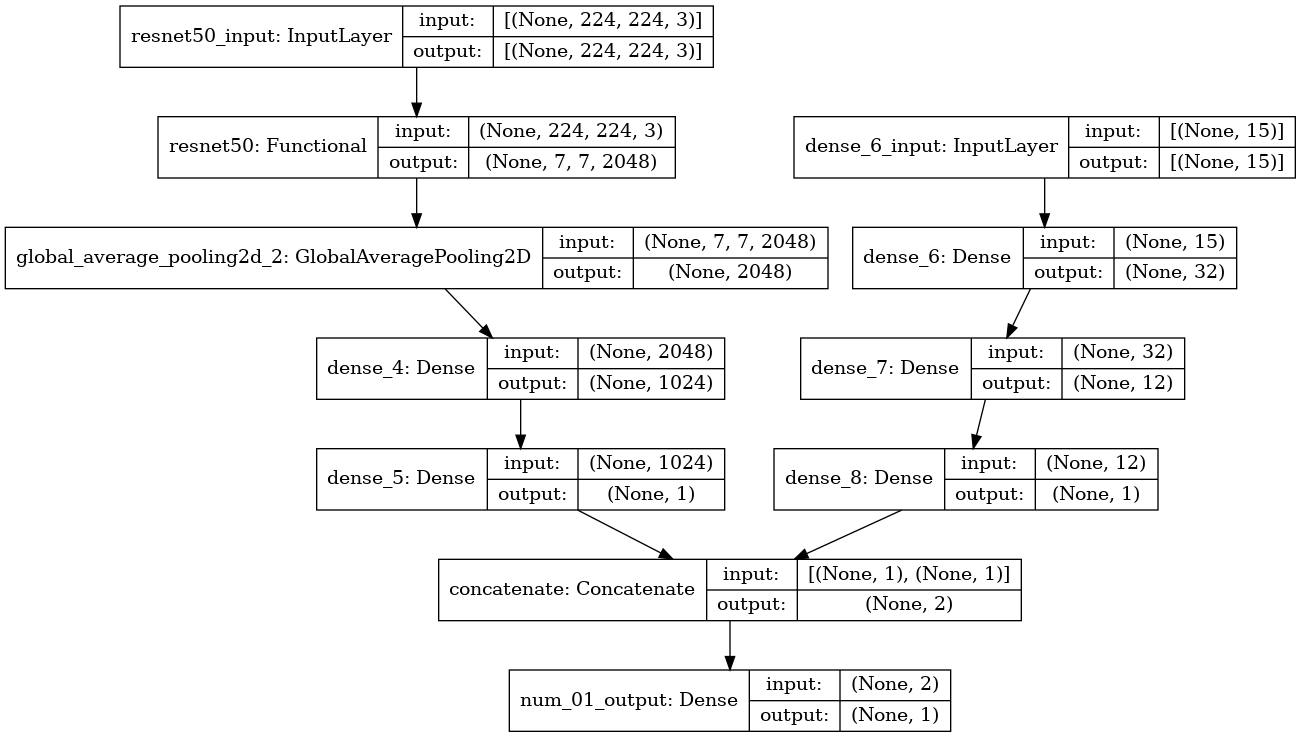

In [32]:
tf.keras.utils.plot_model(concate_model, 'model.png',show_shapes=True,show_layer_names=True)

In [33]:
for layer in concate_model.layers[:-1]:
  layer.trainable = False

In [34]:
concate_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
history_concatenate= concate_model.fit(x=[np.array(images),np.array(train_dataset)[:1000]],
                                       y=np.array(train_dataset_y)[:1000], epochs=50, class_weight=class_weight                                     
)

Epoch 1/50
32/32 [==============================] - 63s 2s/step - loss: 2.5327 - accuracy: 0.0360
Epoch 2/50
32/32 [==============================] - 58s 2s/step - loss: 2.4965 - accuracy: 0.0360
Epoch 3/50
32/32 [==============================] - 58s 2s/step - loss: 2.4673 - accuracy: 0.0360
Epoch 4/50
32/32 [==============================] - 59s 2s/step - loss: 2.4404 - accuracy: 0.0360
Epoch 5/50
32/32 [==============================] - 59s 2s/step - loss: 2.4154 - accuracy: 0.0360
Epoch 6/50
32/32 [==============================] - 58s 2s/step - loss: 2.3933 - accuracy: 0.0360
Epoch 7/50
32/32 [==============================] - 59s 2s/step - loss: 2.3714 - accuracy: 0.0360
Epoch 8/50
32/32 [==============================] - 61s 2s/step - loss: 2.3541 - accuracy: 0.0360
Epoch 9/50
32/32 [==============================] - 61s 2s/step - loss: 2.3384 - accuracy: 0.0360
Epoch 10/50
32/32 [==============================] - 61s 2s/step - loss: 2.3242 - accuracy: 0.0360
Epoch 11/50
32/32 [

In [39]:
concate_model.save('./imagesTextCombined.h5')